### Modeling High-Frequency Limit Order Book Dynamics Using Machine Learning

In [220]:
%matplotlib inline
import pandas as pd
import numpy as np
import time
import statistics
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier,\
                              GradientBoostingClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import *

In [221]:
def read_csv(day_trade):
    data_up = []
    data_down = []
    path = '/Users/daniel/Workspace/SGX-Full-OrderBook-Tick-Data-Trading-Strategy/Data_Transformation/Train_Test_Builder/order_book_3_2014'
    for j,i in enumerate(day_trade):
        for k in range(0,len(i),1):
            path_up = path + '_' + str(j+1) + '_' + str(i[k]) + '_' + 'UP' + '.csv'
            path_down = path + '_' + str(j+1) + '_' + str(i[k]) + '_' + 'DOWN' + '.csv'
            data_up.append(pd.read_csv(path_up))
            data_down.append(pd.read_csv(path_down))
            #print path_down
    return data_up,data_down

### Example : 2014/1/2 

In [222]:
day_trade = [[2]]

In [223]:
data_2014_up, data_2014_down = read_csv(day_trade)

### Column = 0 : label[0 : not traded,1 : traded] & Column = 1~ : Features values 

In [224]:
data_2014_up[0].head(10)

,0,1,2,3,4,5,6,7,8,9,...,58,59,60,61,62,63,64,65,66,67
0,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.553936,4.656716,0.646438,1.532051,0.210127,2.462585,0.422397,10.0,7110.0,7100.0
1,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.553936,4.656716,0.646438,1.532051,0.210127,2.462585,0.422397,10.0,7110.0,7100.0
2,1.0,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,...,-0.497382,0.354839,-0.476190,2.396396,0.411141,1.803571,0.286624,10.0,7125.0,7115.0
3,1.0,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,...,-0.497382,0.354839,-0.476190,1.003774,0.001883,0.909910,-0.047170,10.0,7125.0,7115.0
4,1.0,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,...,-0.926773,0.040590,-0.921986,0.406107,-0.422367,0.268617,-0.576520,10.0,7125.0,7115.0
5,1.0,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,...,-0.926773,0.040590,-0.921986,0.416794,-0.411638,0.275266,-0.568300,10.0,7125.0,7115.0
6,1.0,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,...,-0.926773,0.040590,-0.921986,0.737405,-0.151142,0.474734,-0.356177,10.0,7125.0,7115.0
7,1.0,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,...,-0.922374,0.044280,-0.915194,0.738931,-0.150132,0.477394,-0.353735,10.0,7125.0,7115.0
8,1.0,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,...,-0.922374,0.044280,-0.915194,0.738931,-0.150132,0.477394,-0.353735,10.0,7125.0,7115.0
9,1.0,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,0.21097,...,-0.912188,0.049815,-0.905097,0.741985,-0.148116,0.481383,-0.350090,10.0,7125.0,7115.0


### Machine learning algorithms

In [225]:
models = {
    'RandomForestClassifier': RandomForestClassifier(random_state = 0),
    'ExtraTreesClassifier': ExtraTreesClassifier(random_state = 0),
    'AdaBoostClassifier': AdaBoostClassifier(estimator = DecisionTreeClassifier(),\
                                             n_estimators = 10,random_state = 0),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state = 0),
    'SVC': SVC(probability=True,random_state = 0),
}

### Grids for Hyperparameter Tuning

In [226]:
model_grid_params = {
    'RandomForestClassifier': {'max_features':[None],'n_estimators':[10],'max_depth':[10],\
                               'min_samples_split':[2],'criterion':['entropy'],\
                               'min_samples_leaf':[3]},
    'ExtraTreesClassifier': {'max_features':[None],'n_estimators':[10],'max_depth':[10],\
                             'min_samples_split':[2],'criterion':['entropy'],\
                             'min_samples_leaf':[3]},
    'AdaBoostClassifier': {"estimator__criterion" : ["entropy"],\
                           "estimator__max_depth": [None],\
                           "estimator__min_samples_leaf" : [3],\
                           "estimator__min_samples_split" : [2],\
                           "estimator__max_features" : [None], "algorithm": ["SAMME"]},
    'GradientBoostingClassifier': {'max_features':[None],'n_estimators':[10],'max_depth':[10],\
                                   'min_samples_split':[2],'min_samples_leaf':[3],\
                                   'learning_rate':[0.1],'subsample':[1.0]},
    'SVC': [{'kernel':['rbf'],'gamma':[1e-1],'C':[1]},\
            {'kernel':['linear'],'C':[1,10]}]
}

### Model Selection Pipline

In [227]:
class Model_Selection:
    
    def __init__(self,models,model_grid_params,data_2014,latest_sec,pred_sec,day):
        
        self.models = models
        self.model_grid = model_grid_params
        self.data_2014 = data_2014
        self.latest_sec = latest_sec
        self.pred_sec = pred_sec
        self.day = day
        self.keys = models.keys()
        self.best_score = {}
        self.grid = {}
        self.predict_values = {}
        self.cv_acc = {}
        self.acc = {}
        self.fscore = {}
        self.true_values = {}
        self.predict_values_day = {}
        self.cv_acc_day = {}
        self.acc_day = {}
        self.fscore_day = {}
        self.true_values_day = {}
        self.summary_day = []
        
    def Grid_fit(self,X_train,y_train,cv = 5,scoring = 'accuracy'):
        
        for key in self.keys:
            print("Running GridSearchCV for %s." %(key))
            model = self.models[key]
            model_grid = self.model_grid[key]
            Grid = GridSearchCV(model, model_grid, cv = cv, scoring = scoring)
            Grid.fit(X_train,y_train) 
            self.grid[key] = Grid
            print(Grid.best_params_)
            print('CV Best Score = %s'%(Grid.best_score_))
            self.cv_acc[key].append(Grid.best_score_)  
    
    def model_fit(self,X_train, y_train, X_test, y_test):
        
        for key in self.keys:
            print("Running training & testing for %s." %(key))
            model = self.models[key]
            model.set_params(**self.grid[key].best_params_)
            model.fit(X_train, y_train)
            predictions = model.predict(X_test)
            #print 'Prediction latest 15 second = %s'%(predictions)
            self.predict_values[key].append(predictions.tolist())
            self.true_values[key].append(y_test.tolist())
            acc = metrics.accuracy_score(y_test,predictions)
            f_score = metrics.f1_score(y_test,predictions)
            print('Accuracy = %s'%(acc))
            self.acc[key].append(acc)
            self.fscore[key].append(f_score)
            
            if key == 'SVC':
                if list(self.grid[key].best_params_.values())[0] == 'linear':
                    feature_imp = dict(zip([i for i in range(0,64,1)],model.coef_[0]))
                    Top_five = sorted(feature_imp.items(),key = lambda x : x[1] , reverse=True)[0:5]
                    #print 'Kernel is linear and top five importance features = %s'%(Top_five)
                else:
                    #print 'Kernel is rbf'
                    pass
            else: 
                feature_imp = dict(zip([i for i in range(0,64,1)],model.feature_importances_))
                Top_five = sorted(feature_imp.items(),key = lambda x : x[1] , reverse=True)[0:5]
                #print 'Top five importance features = %s'%(Top_five)
                pass

    def pipline(self):
        
        self.set_list_day() # store day values
        for day in range(0,self.day,1):
            self.set_list() # store values
            print('Day = %s'%(day+1))
            for i in range(0,1000,self.pred_sec):#9000-self.latest_sec-600,self.pred_sec):
            # for i in range(0,9000-self.latest_sec-600,self.pred_sec):
                
                print('--------------------Rolling Window Time = %s--------------------'%(i/pred_sec))
                # Train data
                data_train = self.data_2014[day][i:i+self.latest_sec]
                X_train = data_train.drop(['0','65','66','67'],axis=1)
                y_train = data_train['0']

                # Test data
                data_test = self.data_2014[day][i + self.latest_sec:i + self.latest_sec + self.pred_sec]
                X_test = data_test.drop(['0','65','66','67'],axis=1)
                y_test = data_test['0']
                
                #start = time.time()
                self.Grid_fit(X_train, y_train, cv = 5, scoring = 'accuracy')
                self.model_fit(X_train, y_train,X_test,y_test)
                #end = time.time()
                #print 'Total Time = %s'%(end - start)
                
            for key in self.keys:
                
                self.cv_acc_day[key].append(self.cv_acc[key])
                self.acc_day[key].append(self.acc[key])
                self.fscore_day[key].append(self.fscore[key])
                self.true_values_day[key].append(self.true_values[key])
                self.predict_values_day[key].append(self.predict_values[key])
            
            self.summary_day.append(self.score_summary(sort_by = 'Accuracy_mean'))
    
    def set_list(self):
        
        for key in self.keys:
            self.predict_values[key] = []
            self.cv_acc[key] = []
            self.acc[key] = []
            self.fscore[key] = []
            self.true_values[key] = []
            
    def set_list_day(self):
        
        for key in self.keys:
            self.predict_values_day[key] = []
            self.cv_acc_day[key] = []
            self.acc_day[key] = []
            self.fscore_day[key] = []
            self.true_values_day[key] = []
            
    def score_summary(self,sort_by):
        
        summary = pd.concat([pd.DataFrame(self.acc.keys()),
                             pd.DataFrame(map(lambda x: np.mean(self.acc[x]), self.acc)),\
                             pd.DataFrame(map(lambda x: np.std(self.acc[x]), self.acc)),\
                             pd.DataFrame(map(lambda x: max(self.acc[x]), self.acc)),\
                             pd.DataFrame(map(lambda x: min(self.acc[x]), self.acc)),\
                             pd.DataFrame(map(lambda x: np.mean(self.fscore[x]), self.fscore))],axis=1)
        summary.columns = ['Estimator','Accuracy_mean','Accuracy_std','Accuracy_max','Accuracy_min','F_score']
        summary.index.rename('Ranking', inplace=True)
        return summary.sort_values(by = [sort_by], ascending=False)
          
    def print_(self):
        print(self.predict_values)


In [228]:
latest_sec = 60 * 30
pred_sec = 10
day = 1
data_2014_up, data_2014_down = read_csv(day_trade)
data_2014 = data_2014_up
pip = Model_Selection(models,model_grid_params,data_2014,latest_sec,pred_sec,day)

### Start Machine Learning Pipline

In [229]:
start = time.time()
pip.pipline()
end = time.time()
print('Total Time = %s'%(end-start))

Day = 1
--------------------Rolling Window Time = 0.0--------------------
Running GridSearchCV for RandomForestClassifier.
{'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 10}
CV Best Score = 0.7227777777777777
Running GridSearchCV for ExtraTreesClassifier.
{'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 10}
CV Best Score = 0.7405555555555556
Running GridSearchCV for AdaBoostClassifier.
{'algorithm': 'SAMME', 'estimator__criterion': 'entropy', 'estimator__max_depth': None, 'estimator__max_features': None, 'estimator__min_samples_leaf': 3, 'estimator__min_samples_split': 2}
CV Best Score = 0.7305555555555555
Running GridSearchCV for GradientBoostingClassifier.
{'learning_rate': 0.1, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 10, 'subsample': 1.0}
CV Best Score = 0.7172222222

/Users/daniel/Workspace/SGX-Full-OrderBook-Tick-Data-Trading-Strategy/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/daniel/Workspace/SGX-Full-OrderBook-Tick-Data-Trading-Strategy/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy = 1.0
Running training & testing for GradientBoostingClassifier.


/Users/daniel/Workspace/SGX-Full-OrderBook-Tick-Data-Trading-Strategy/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy = 1.0
Running training & testing for SVC.
Accuracy = 0.0
--------------------Rolling Window Time = 47.0--------------------
Running GridSearchCV for RandomForestClassifier.
{'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 10}
CV Best Score = 0.7905555555555555
Running GridSearchCV for ExtraTreesClassifier.
{'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 10}
CV Best Score = 0.8005555555555557
Running GridSearchCV for AdaBoostClassifier.
{'algorithm': 'SAMME', 'estimator__criterion': 'entropy', 'estimator__max_depth': None, 'estimator__max_features': None, 'estimator__min_samples_leaf': 3, 'estimator__min_samples_split': 2}
CV Best Score = 0.8277777777777778
Running GridSearchCV for GradientBoostingClassifier.
{'learning_rate': 0.1, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_esti

/Users/daniel/Workspace/SGX-Full-OrderBook-Tick-Data-Trading-Strategy/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy = 1.0
Running training & testing for GradientBoostingClassifier.


/Users/daniel/Workspace/SGX-Full-OrderBook-Tick-Data-Trading-Strategy/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy = 1.0
Running training & testing for SVC.
Accuracy = 0.0
--------------------Rolling Window Time = 48.0--------------------
Running GridSearchCV for RandomForestClassifier.
{'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 10}
CV Best Score = 0.8116666666666668
Running GridSearchCV for ExtraTreesClassifier.
{'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 10}
CV Best Score = 0.7711111111111111
Running GridSearchCV for AdaBoostClassifier.
{'algorithm': 'SAMME', 'estimator__criterion': 'entropy', 'estimator__max_depth': None, 'estimator__max_features': None, 'estimator__min_samples_leaf': 3, 'estimator__min_samples_split': 2}
CV Best Score = 0.8099999999999999
Running GridSearchCV for GradientBoostingClassifier.
{'learning_rate': 0.1, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_esti

/Users/daniel/Workspace/SGX-Full-OrderBook-Tick-Data-Trading-Strategy/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/daniel/Workspace/SGX-Full-OrderBook-Tick-Data-Trading-Strategy/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy = 0.4
Running training & testing for GradientBoostingClassifier.


/Users/daniel/Workspace/SGX-Full-OrderBook-Tick-Data-Trading-Strategy/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy = 1.0
Running training & testing for SVC.
Accuracy = 0.6
--------------------Rolling Window Time = 49.0--------------------
Running GridSearchCV for RandomForestClassifier.
{'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 10}
CV Best Score = 0.7766666666666666
Running GridSearchCV for ExtraTreesClassifier.
{'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 10}
CV Best Score = 0.7849999999999999
Running GridSearchCV for AdaBoostClassifier.
{'algorithm': 'SAMME', 'estimator__criterion': 'entropy', 'estimator__max_depth': None, 'estimator__max_features': None, 'estimator__min_samples_leaf': 3, 'estimator__min_samples_split': 2}
CV Best Score = 0.8138888888888889
Running GridSearchCV for GradientBoostingClassifier.
{'learning_rate': 0.1, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_esti

/Users/daniel/Workspace/SGX-Full-OrderBook-Tick-Data-Trading-Strategy/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/daniel/Workspace/SGX-Full-OrderBook-Tick-Data-Trading-Strategy/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy = 1.0
Running training & testing for GradientBoostingClassifier.


/Users/daniel/Workspace/SGX-Full-OrderBook-Tick-Data-Trading-Strategy/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy = 1.0
Running training & testing for SVC.
Accuracy = 0.6
--------------------Rolling Window Time = 50.0--------------------
Running GridSearchCV for RandomForestClassifier.
{'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 10}
CV Best Score = 0.8377777777777776
Running GridSearchCV for ExtraTreesClassifier.
{'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 10}
CV Best Score = 0.7894444444444444
Running GridSearchCV for AdaBoostClassifier.
{'algorithm': 'SAMME', 'estimator__criterion': 'entropy', 'estimator__max_depth': None, 'estimator__max_features': None, 'estimator__min_samples_leaf': 3, 'estimator__min_samples_split': 2}
CV Best Score = 0.8566666666666667
Running GridSearchCV for GradientBoostingClassifier.
{'learning_rate': 0.1, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_esti

/Users/daniel/Workspace/SGX-Full-OrderBook-Tick-Data-Trading-Strategy/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/daniel/Workspace/SGX-Full-OrderBook-Tick-Data-Trading-Strategy/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/daniel/Workspace/SGX-Full-OrderBook-Tick-Data-Trading-Strategy/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicte

Accuracy = 1.0
Running training & testing for GradientBoostingClassifier.


/Users/daniel/Workspace/SGX-Full-OrderBook-Tick-Data-Trading-Strategy/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy = 1.0
Running training & testing for SVC.


/Users/daniel/Workspace/SGX-Full-OrderBook-Tick-Data-Trading-Strategy/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy = 1.0
--------------------Rolling Window Time = 51.0--------------------
Running GridSearchCV for RandomForestClassifier.
{'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 10}
CV Best Score = 0.845
Running GridSearchCV for ExtraTreesClassifier.
{'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 10}
CV Best Score = 0.7861111111111112
Running GridSearchCV for AdaBoostClassifier.
{'algorithm': 'SAMME', 'estimator__criterion': 'entropy', 'estimator__max_depth': None, 'estimator__max_features': None, 'estimator__min_samples_leaf': 3, 'estimator__min_samples_split': 2}
CV Best Score = 0.8466666666666667
Running GridSearchCV for GradientBoostingClassifier.
{'learning_rate': 0.1, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 10, 'subsample': 1.0}
CV Best Score = 0.850555555555555

/Users/daniel/Workspace/SGX-Full-OrderBook-Tick-Data-Trading-Strategy/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy = 1.0
Running training & testing for GradientBoostingClassifier.


/Users/daniel/Workspace/SGX-Full-OrderBook-Tick-Data-Trading-Strategy/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy = 1.0
Running training & testing for SVC.
Accuracy = 0.9
--------------------Rolling Window Time = 52.0--------------------
Running GridSearchCV for RandomForestClassifier.
{'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 10}
CV Best Score = 0.8138888888888889
Running GridSearchCV for ExtraTreesClassifier.
{'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 10}
CV Best Score = 0.7744444444444444
Running GridSearchCV for AdaBoostClassifier.
{'algorithm': 'SAMME', 'estimator__criterion': 'entropy', 'estimator__max_depth': None, 'estimator__max_features': None, 'estimator__min_samples_leaf': 3, 'estimator__min_samples_split': 2}
CV Best Score = 0.8088888888888889
Running GridSearchCV for GradientBoostingClassifier.
{'learning_rate': 0.1, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_esti

/Users/daniel/Workspace/SGX-Full-OrderBook-Tick-Data-Trading-Strategy/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/daniel/Workspace/SGX-Full-OrderBook-Tick-Data-Trading-Strategy/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/daniel/Workspace/SGX-Full-OrderBook-Tick-Data-Trading-Strategy/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicte

Accuracy = 1.0
Running training & testing for GradientBoostingClassifier.


/Users/daniel/Workspace/SGX-Full-OrderBook-Tick-Data-Trading-Strategy/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy = 1.0
Running training & testing for SVC.


/Users/daniel/Workspace/SGX-Full-OrderBook-Tick-Data-Trading-Strategy/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy = 1.0
--------------------Rolling Window Time = 53.0--------------------
Running GridSearchCV for RandomForestClassifier.
{'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 10}
CV Best Score = 0.7933333333333333
Running GridSearchCV for ExtraTreesClassifier.
{'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 10}
CV Best Score = 0.7072222222222222
Running GridSearchCV for AdaBoostClassifier.
{'algorithm': 'SAMME', 'estimator__criterion': 'entropy', 'estimator__max_depth': None, 'estimator__max_features': None, 'estimator__min_samples_leaf': 3, 'estimator__min_samples_split': 2}
CV Best Score = 0.8188888888888888
Running GridSearchCV for GradientBoostingClassifier.
{'learning_rate': 0.1, 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 10, 'subsample': 1.0}
CV Best Score = 0.81

### Metrics 

In [230]:

print(len(pip.summary_day))
for day in range(0, len(pip.summary_day)):
    print(day)
    print(pip.summary_day[day])#.reset_index(drop = True)

1
0
                          Estimator  Accuracy_mean  Accuracy_std  \
Ranking                                                            
1              ExtraTreesClassifier          0.946      0.159009   
3        GradientBoostingClassifier          0.945      0.190460   
2                AdaBoostClassifier          0.944      0.158316   
0            RandomForestClassifier          0.922      0.207644   
4                               SVC          0.894      0.237411   

         Accuracy_max  Accuracy_min   F_score  
Ranking                                        
1                 1.0           0.1  0.891562  
3                 1.0           0.0  0.884061  
2                 1.0           0.2  0.895190  
0                 1.0           0.0  0.879891  
4                 1.0           0.0  0.873300  


Text(0, 0.5, 'Price')

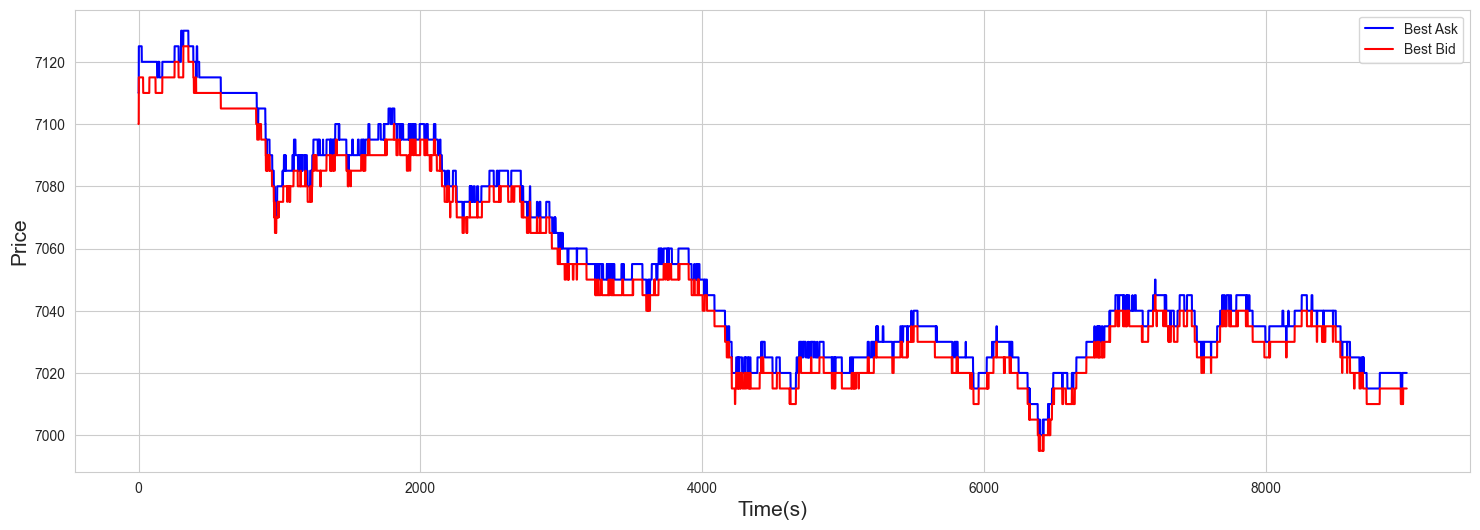

In [231]:
sns.set_style("whitegrid")
plt.figure(figsize = (18,6))
color_ = ['r','b']
plot(data_2014[0]['66'],label = 'Best Ask',color = color_[1])
plot(data_2014[0]['67'],label = 'Best Bid',color = color_[0])
plt.legend(loc=0)
plt.xlabel('Time(s)',size = 15)
plt.ylabel('Price',size = 15)

### Accuracy in one day

Text(0, 0.5, 'Accuracy')

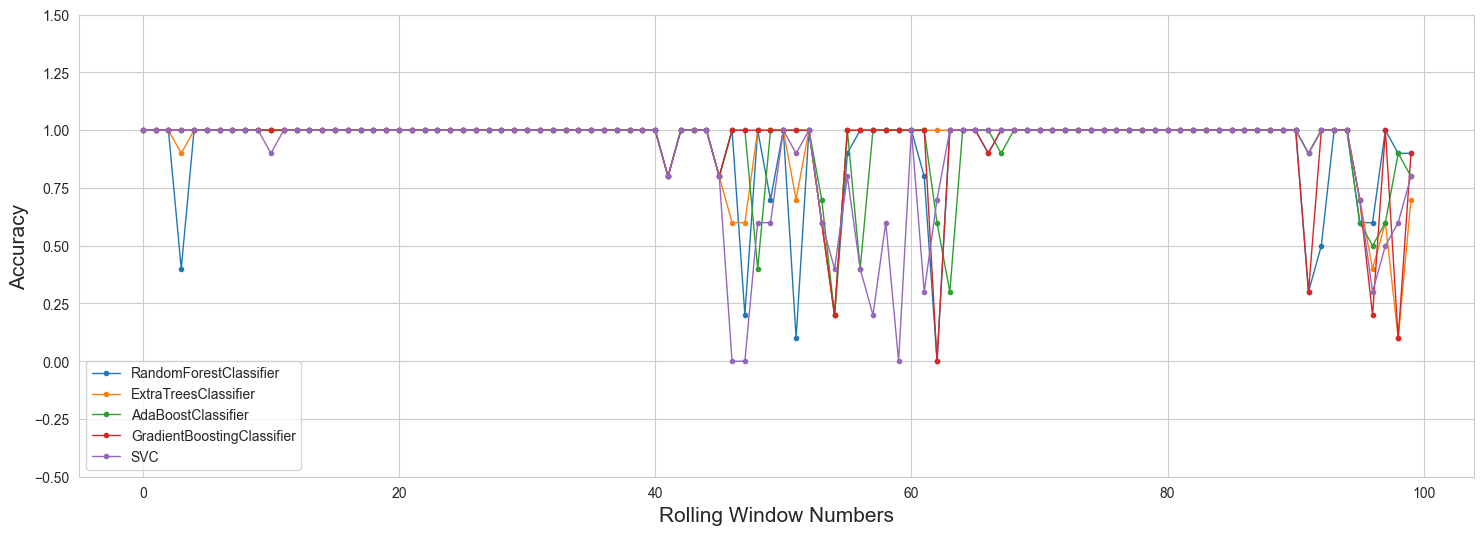

In [232]:
sns.set_style("whitegrid")
plt.figure(figsize = (18,6))
color = []
for key in pip.keys:
    plot(np.array(pip.acc_day[key])[0],'-o',label = key,lw = 1,markersize = 3)
    plt.legend(loc=0)
plt.ylim(-0.5,1.5)
plt.legend(loc=0)
plt.xlabel('Rolling Window Numbers',size = 15)
plt.ylabel('Accuracy',size = 15)

### Cross Validation 

Text(0, 0.5, 'CV Mean Accuracy')

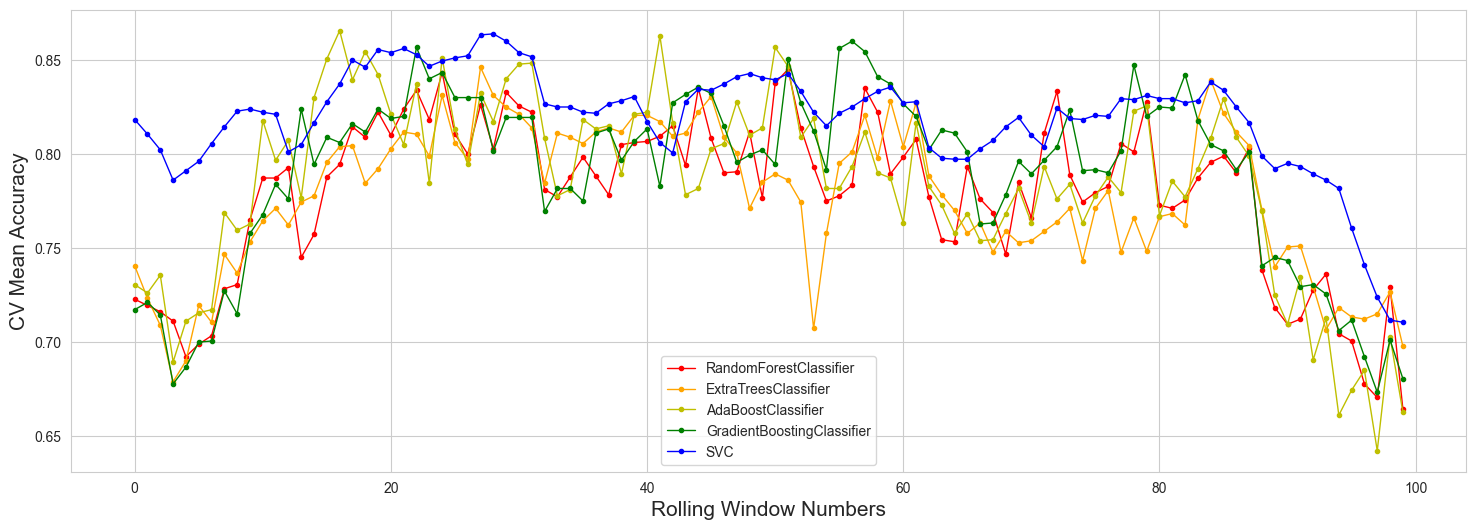

In [233]:
sns.set_style("whitegrid")
plt.figure(figsize = (18,6))
color_ = ['r','orange','y','g','b']
for index,key in enumerate(pip.keys):
    plot(np.array(pip.cv_acc_day[key])[0],'-o',label = key,color = color_[index],lw = 1,markersize = 3)
#plot(best_cv_score,'-v',label = 'Best cv 5 folds score',color = 'violet',lw = 1,markersize = 6)
plt.legend(loc=0)
plt.xlabel('Rolling Window Numbers',size = 15)
plt.ylabel('CV Mean Accuracy',size = 15)

### Best Model

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'CV Mean Accuracy')

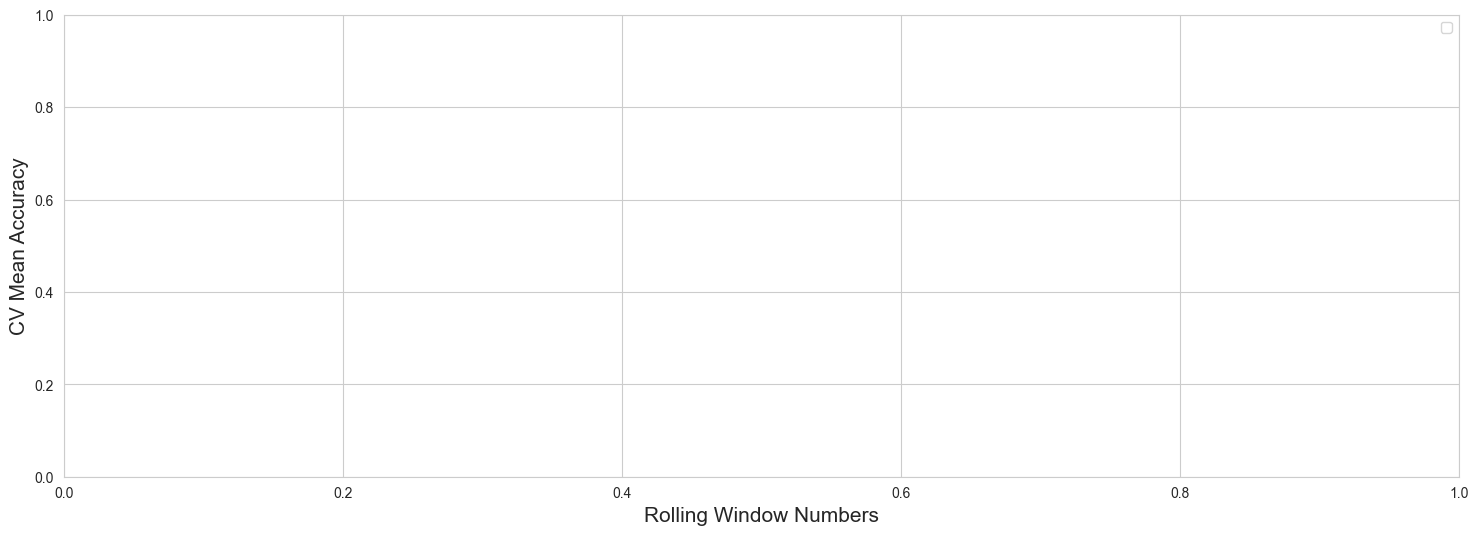

In [234]:
sns.set_style("whitegrid")
plt.figure(figsize = (18,6))
# plot(best_cv_score,'-o',label = 'Best cv 5 folds score',color = 'violet',lw = 1,markersize = 5)
plt.legend(loc=0)
plt.xlabel('Rolling Window Numbers',size = 15)
plt.ylabel('CV Mean Accuracy',size = 15)

(0.55, 1.0)

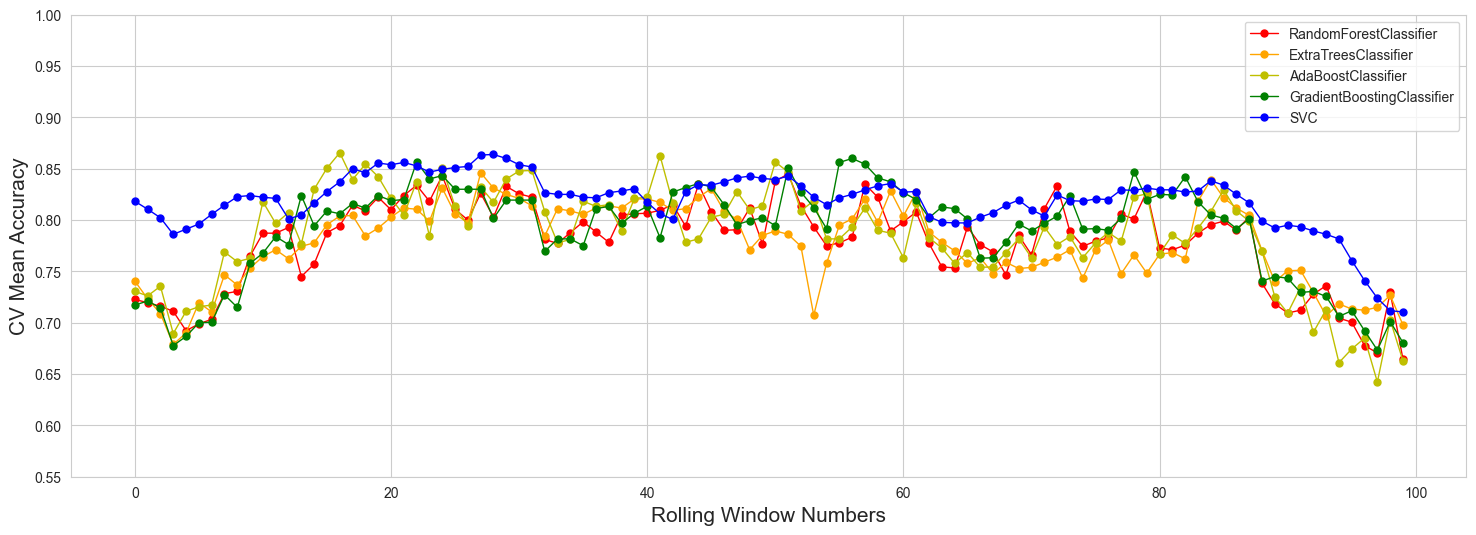

In [235]:
sns.set_style("whitegrid")
plt.figure(figsize = (18,6))
color_ = ['r','orange','y','g','b']
for index,key in enumerate(pip.keys):
    plot(np.array(pip.cv_acc_day[key])[0][0:250],'-o',label = key,color = color_[index],lw = 1,markersize = 5)
#plot(best_cv_score,'-v',label = 'Best cv 5 folds score',color = 'violet',lw = 1,markersize = 6)
plt.legend(loc=0)
plt.xlabel('Rolling Window Numbers',size = 15)
plt.ylabel('CV Mean Accuracy',size = 15)
plt.ylim(0.55,1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(0.55, 1.0)

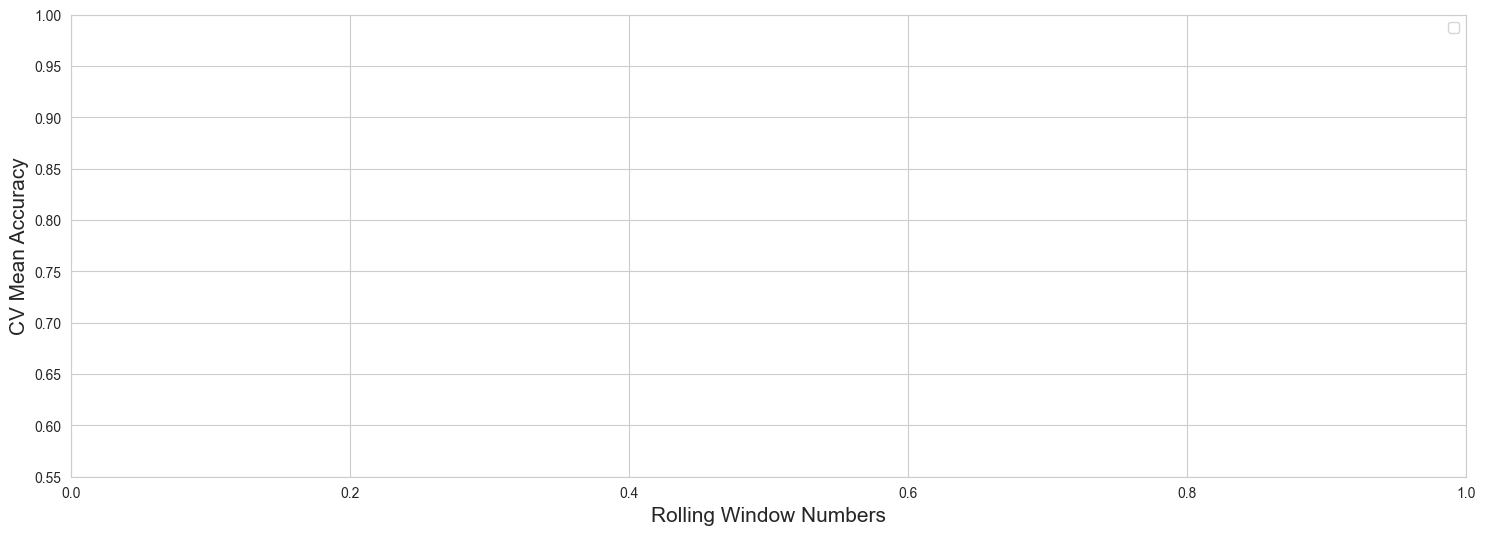

In [236]:
sns.set_style("whitegrid")
plt.figure(figsize = (18,6))
# plot(best_cv_score[0:250],'-o',label = 'Best cv 5 folds score',color = 'violet',lw = 1,markersize = 5)
plt.legend(loc=0)
plt.xlabel('Rolling Window Numbers',size = 15)
plt.ylabel('CV Mean Accuracy',size = 15)
plt.ylim(0.55,1)

### Profit & Loss

In [237]:
# compute cum_profit and Best_cv_score
dict_ = {}
dict_['cum_profit'] = []
dict_['Best_cv_score'] = []


for day in range(0,1,1):
    cum_profit_label = []
    cum_profit = []
    best_cv_score = []
    spread = 0.2 * data_2014[day]['65'][1800:][9::10].values
    loss = 0.2*(data_2014[0]['67'][1800:9000-600][9::10].values - data_2014[day]['67'][1800+600:9000][9::10].values)
    for j in range(0,len(list(pip.cv_acc_day.values())[0][day]),1):
        max_al = {}
        keys = list(pip.keys)
        for i in range(0,len(keys),1):
            key = keys[i]
            max_al[key] = np.array(pip.cv_acc_day[key])[day][j]
        # select best algorithm in cv = 5    
        top_cv_acc = sorted(max_al.items(),key = lambda x : x[1], reverse = True)[0:1][0]
        best_cv_score.append(top_cv_acc[1])
        submission = pip.predict_values_day[top_cv_acc[0]][day][j][-1]
        true_value = pip.true_values_day[top_cv_acc[0]][day][j][-1]

        if submission == true_value:
            if submission == 1:
                cum_profit_label.append(1)
                cum_profit.append(spread[j])
            elif submission == 0:
                cum_profit_label.append(0)
                cum_profit.append(0)
        elif submission != true_value:
            if submission == 1:
                cum_profit_label.append(-1)
                cum_profit.append(loss[j])
            elif submission == 0:
                cum_profit_label.append(0)
                cum_profit.append(0)
                
    dict_['cum_profit'].append(cum_profit)
    dict_['Best_cv_score'].append(best_cv_score)

Text(0, 0.5, 'Profit')

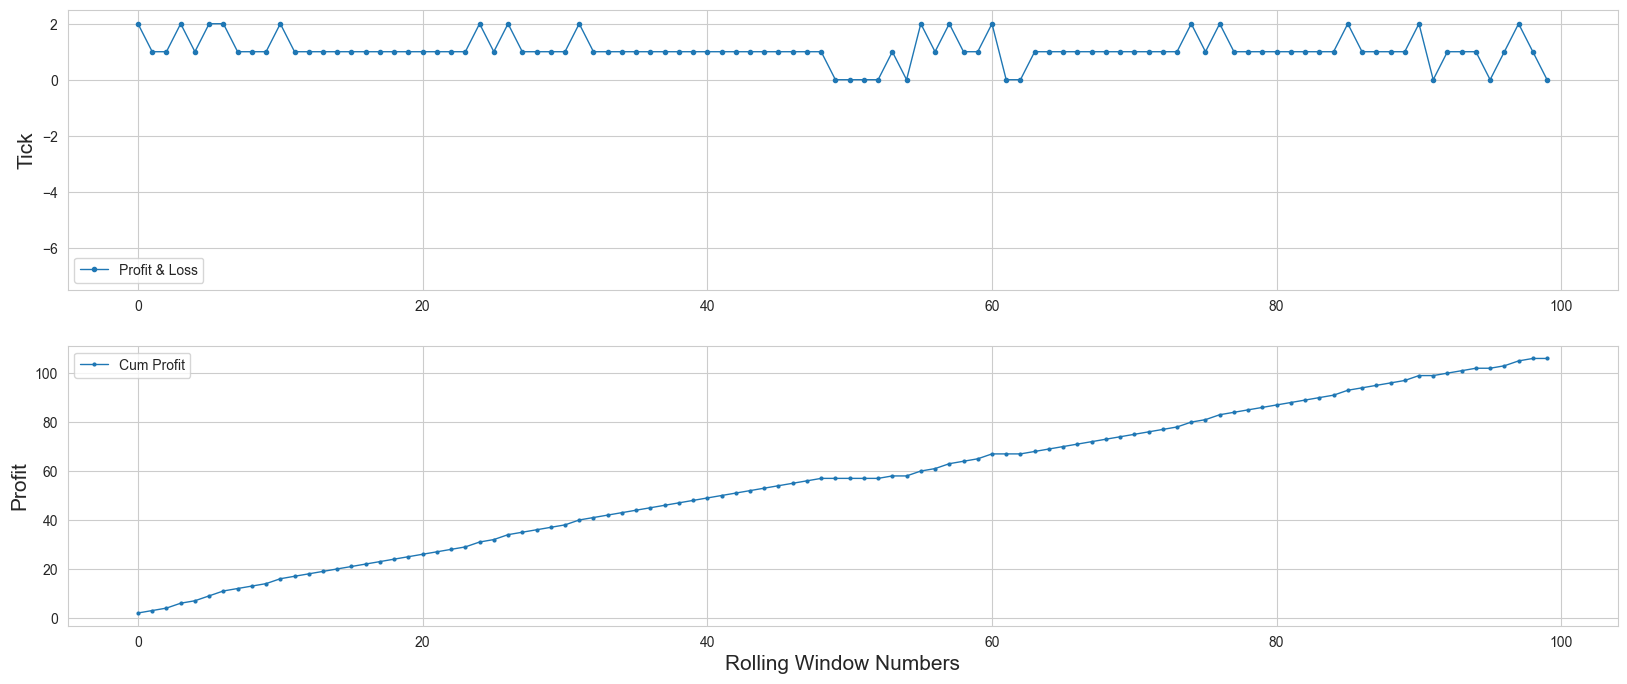

In [238]:
sns.set_style("whitegrid")
plt.figure(figsize = (20,8))
plt.subplot(211)
plot(cum_profit,'-o',label = 'Profit & Loss',lw = 1,markersize = 3)
plt.ylabel('Tick',size = 15)
plt.legend(loc=0)
plt.ylim(-7.5,2.5)
plt.subplot(212)
plot(np.cumsum(cum_profit),'-o',label = 'Cum Profit',lw = 1,markersize = 2)
plt.legend(loc=0)
plt.xlabel('Rolling Window Numbers',size = 15)
plt.ylabel('Profit',size = 15)